# Initialization Strategies and Cross Entropy Loss
#### Description:
We explore different initialization strategies for a network and evalute the performance of the network on the FashionMNIST dataset. We implement orthogonal and uniform initialization, and use the PyTorch implementation of Xavier initialization. We also implement a Cross Entropy Loss function

In [20]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.autograd import Variable
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

from torch.nn.parameter import Parameter
import pdb

In [0]:
class Conv2d(nn.Module):
  def __init__(self, n_channels, out_channels, kernel_size, init_strategy='xav', stride=1, padding=0, dilation=1, groups=1, bias=True):
    self.__dict__.update(locals()) 
    # add as members of this class all parameters passed to initializer function
    # i.e. self.n_channels = n_channels, self.out_channels, etc.)
    super(Conv2d, self).__init__()
    self.weight = Parameter(torch.Tensor(self.out_channels, #Parameter holds data but also allows grad and other useful functions
                               self.n_channels, 
                               kernel_size[0], 
                               kernel_size[1])) # (4d tensor of size out x in x k x k) 3x3 kernel with out output channels and in input channels
    
    self.bias = Parameter(torch.Tensor(out_channels))
    self.bias.data.uniform_(0, 0)
    
    if init_strategy == 'xav':
      # Xavier Initialization
      torch.nn.init.xavier_uniform_(self.weight)
    elif init_strategy == 'orth':
      # Orthogonal Initialization:
      M = np.random.random((self.out_channels, self.n_channels * kernel_size[0] * kernel_size[1])).astype(np.float32)
      U, _, Vt = np.linalg.svd(M, full_matrices=False)
      if len(M) > len(M[0]): # If M has more rows than columns, take U instead of V. See https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers
        W = U.reshape((self.out_channels, self.n_channels, kernel_size[0], kernel_size[1]))
      else:
        W = Vt.reshape((self.out_channels, self.n_channels, kernel_size[0], kernel_size[1]))
      self.weight.data = torch.from_numpy(W) # Sends those weights to the weight matrix
    elif init_strategy == 'uni':
      # Uniform
      self.weight.data.uniform_(-1, 1)
    else:
      # Xavier Initialization
      torch.nn.init.xavier_uniform_(self.weight)

    
  def forward(self, x): 
    return F.conv2d(x, self.weight, self.bias, self.stride, # Torch functionals are like layers or modules (pytorch) except they are the actual functions that run the code (in C or in Cuda)
                    self.padding, self.dilation, self.groups)
  
  
class ConvNetwork(nn.Module):
  def __init__(self, dataset, initialization_strategy='xav'):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10  # number of final output channels, correspond to 10 classes. The network will output 10 weights for 10 classes.
    
    self.net = nn.Sequential(
      Conv2d(c, 10, (3, 3), init_strategy=initialization_strategy, padding=(1,1)),   # c = channels in input image (1 in fashion mnist), 10 = number of 
#         # kernels, (3, 3) is the size of the convolution kernel, 
#         # padding = amount of implicit zero padding in each dimension
      nn.ReLU(),
      Conv2d(10, 64, (3, 3), init_strategy=initialization_strategy, padding=(1,1)), # First argument matches the second argument of previous layer
#         # (28, 28) says that we learn a kernel that produces a single number from the whole image)
      nn.ReLU(),
      Conv2d(64, 50, (28, 28), init_strategy=initialization_strategy, padding=(0,0)), # First argument matches the second argument of previous layer
      nn.ReLU(),
      Conv2d(50, output, (1, 1), init_strategy=initialization_strategy, padding=(0,0)), # First argument matches the second argument of previous layer
    ) # Should produce a batch_size x 10 x 1 x 1 tensor
    
  def forward(self, x):
    # Returns the network's best guess for the y associated with x:
    # (n, 10, 1, 1)
    # (n, 10, 1)
    # (n, 10)
    return self.net(x).squeeze(2).squeeze(2)
  
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, 
                                      train=train,
                                      transform=transforms.ToTensor(),
                                      download=True)
    
  def __getitem__(self, i):
    # Overrides the [] operator
    x, y = self.data[i]
#     pdb.set_trace() # Ctrl + D to quit.
    return x, y
    
  def __len__(self):
    # Can overload to train on a smaller portion of the dataset
#     return (100)
    return len(self.data) // 5

class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
    
  def forward(self, y_truth, y_hat):
    maxes, _ = torch.max(y_hat, 1, keepdim=True)
    y_hat = y_hat - maxes
    y_hat = torch.exp(y_hat)
    y_hat = y_hat/torch.sum(y_hat, 1, keepdim=True)
    return -torch.sum((torch.mul(y_truth.float(), torch.log(y_hat).float())))

def OneHotEncode(y):
    y = y.numpy()
    y_onehot = np.zeros((y.size, 10))
    y_onehot[np.arange(y.size), y] = 1
    y_onehot = torch.from_numpy(y_onehot)
    y_onehot = y_onehot.cuda(async=True)
    return y_onehot

def train(init_strategy='xav'):
  
  train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist') # train=True unnecessary, defaults to True
  val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

  model = ConvNetwork(train_dataset, init_strategy)
  model = model.cuda()
  objective = CrossEntropyLoss() # nn.CrossEntropyLoss is the built-in Cross Entropy Loss
  optimizer = optim.Adam(model.parameters(), lr=1e-4) # Weights and bias, learning rate
  train_loader = DataLoader(train_dataset,  # You can change the way that your batch is shuffled
                           batch_size=42,   # You can also spin up multiple workers to work on multiple threads
                           pin_memory=True) # Speed improvement, says that you want it in the same part of the GPU every time. Because of this, the GPU puts the data in parts of the GPU that are easier to write to
  validation_loader = DataLoader(val_dataset,
                           batch_size=42,
                           pin_memory=True)

  train_losses = []
  validation_losses = []
  accuracies = []

  num_epochs = 8

  loop = tqdm(total=len(train_loader) * num_epochs, position=0)

  for epoch in range(num_epochs):

    for batch, (x, y_truth) in enumerate(train_loader):

      y_onehot = OneHotEncode(y_truth)
      optimizer.zero_grad() # Set the gradient to zero

      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
      y_hat = model(x)

      loss = objective(y_onehot, y_hat)

      if epoch % 2 == 0 and batch == 0:

        train_losses.append(loss)

        val_loss = np.mean([objective(OneHotEncode(val_y), model(val_x.cuda())).item() for val_x, val_y in validation_loader])
        validation_losses.append((len(validation_losses), val_loss))  # A tuple, essentially an enumeration of the losses

        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracies.append(accuracy)

      loop.set_description('loss:{:.4f}, accuracy{:.4f}. '.format(loss.item(), accuracy)) # loss.item() returns the simple float loss, not the entire loss tensor
      loop.update(1)

      loss.backward() # Compute the gradient for each weight with respect to the loss
      optimizer.step() # Take a step in the direction of the negative gradient
      batch += 1

  loop.close()

  a, b = zip(*validation_losses)
  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  axes[0].plot(a, train_losses, label='train')
  axes[0].plot(a, b, label='validation')
  axes[0].set_title("Training and validation loss over epochs")
  axes[0].set_ylabel("Cross Entropy Loss")
  axes[0].set_xlabel("Epoch / 2")
  axes[0].legend()
  axes[1].plot(a, accuracies, label='accuracy')
  axes[1].set_title("Training and validation loss over epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].set_xlabel("Epoch / 2")
  axes[1].legend()
  plt.show()
  num_params = sum([torch.numel(layer) for layer in model.parameters()])

  print("\nNumber of parameters in network: {}".format(num_params))

  # REMEMBER TO TEST FUNCTIONALITY OF PROGRAM ON A SMALL SUBSET OF DATA FIRST

# Xavier Initialization

loss:0.1054, accuracy1.0000. : 100%|██████████| 300/300 [00:08<00:00, 34.76it/s]


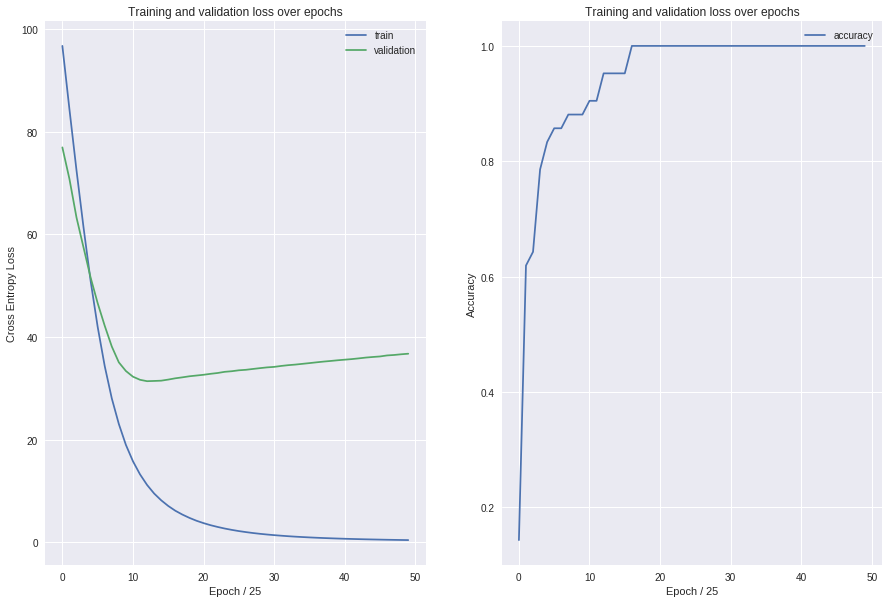


Number of parameters in network: 2515284


In [38]:
train('xav')

# Orthogonal Initialization

loss:0.1440, accuracy0.8333. : 100%|██████████| 300/300 [00:08<00:00, 36.59it/s]


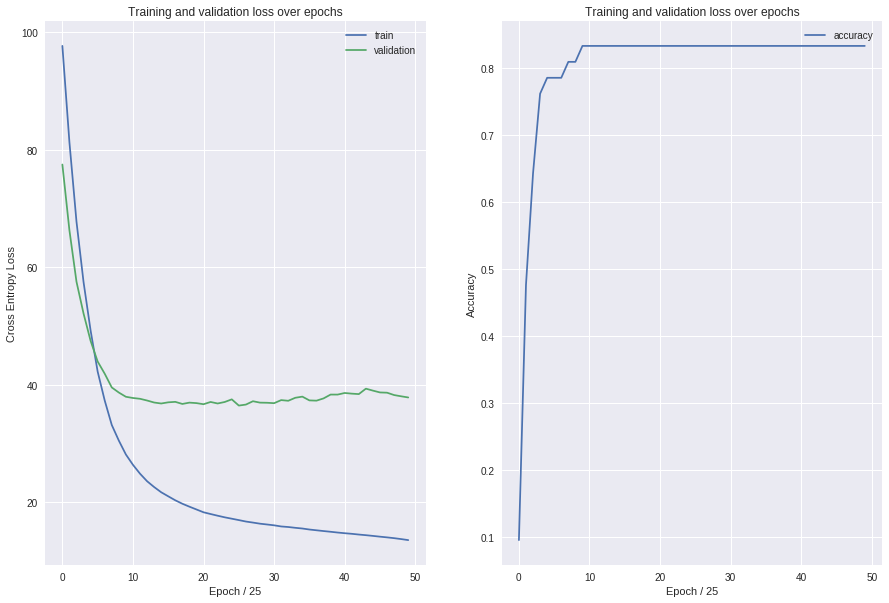


Number of parameters in network: 2515284


In [40]:
train('orth')

# Uniform Initialization

loss:nan, accuracy0.1667. : 100%|██████████| 300/300 [00:08<00:00, 33.66it/s]


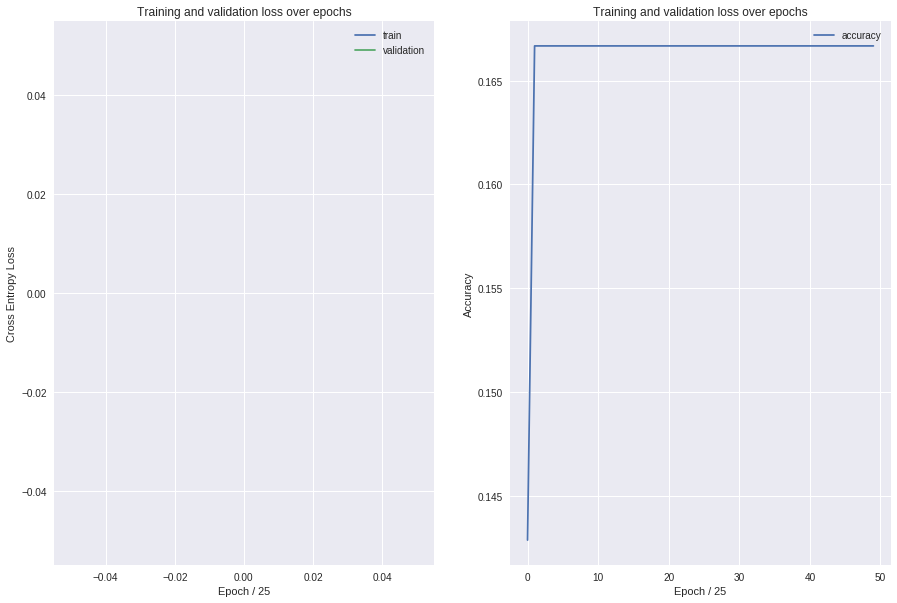


Number of parameters in network: 2515284


In [41]:
train('uni')

# Fully Trained Network

loss:9.2740, accuracy0.9286. : 100%|██████████| 2288/2288 [00:58<00:00, 38.93it/s]


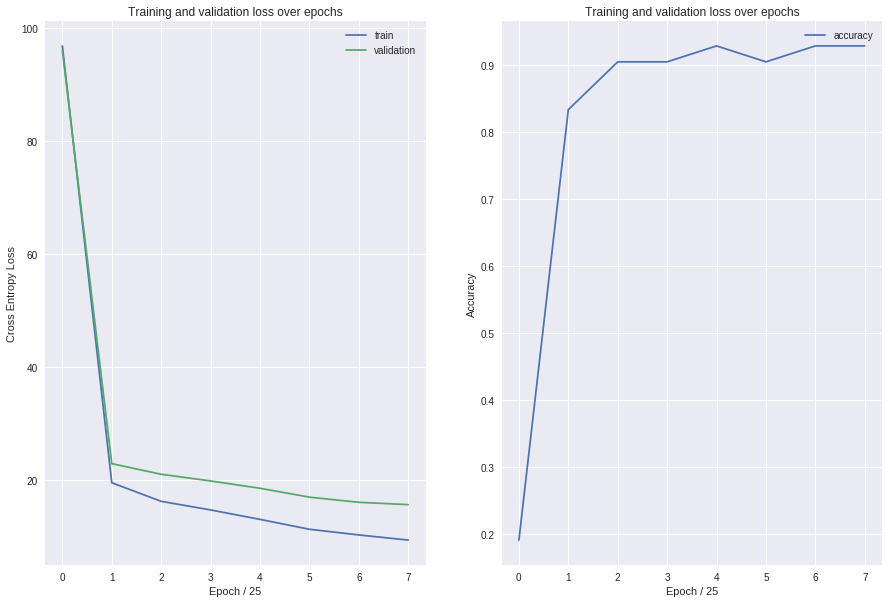


Number of parameters in network: 2515284


In [54]:
train('xav')